# FEM Modelling for Single-Phase STEDIN Transformer

### Transient Analysis

In time-domain,
\begin{equation}
    -\nabla\cdot\Big[\frac{1}{\mu}\nabla u_z \Big] + \sigma \frac{\partial u_z}{\partial t} = J_0
\end{equation}

Writing in matrix form, 
\begin{equation}
    Au + B \frac{\partial u}{\partial t} = f
\end{equation}

Using Backward Euler method for time-stepping, 
\begin{equation}
    Au^{t+\Delta t} + B \frac{u^{t+\Delta t} - u^{t}}{\Delta t} = f^{t+\Delta t}
\end{equation}

On simplifying, we get,
\begin{equation}
    [B + \Delta t A]u^{t+\Delta t} = Bu^t + \Delta t f^t
\end{equation}

## Import Packages

In [1]:
print(" ▸ Loading Packages .... \r")
start = time_ns()
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_Transient_Tri_1e.jl");
using .FEM_Transient_Tri_1e
include("../../../../lib/Post_Process_Time.jl");
using .Post_Process_Time
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Packages loaded ("*string(elapsed)*" seconds)                               ")

 ✓ Packages loaded (24.31 seconds)                               


## Julia code

In [2]:
gmsh.initialize()

## Read mesh from file
print(" ▸ Reading mesh file .... \r")
start = time_ns()
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh file loaded ("*string(elapsed)*" seconds)                               ")

print(" ▸ Generating required mesh data .... \r")
start = time_ns()
mesh_data = get_mesh_data_tri_1e(gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh data generated ("*string(elapsed)*" seconds)                               ")

print(" ▸ Setting initial parameters .... \r")
start = time_ns()
S = 400e3;                    # Power rating
Vp = 10750 * sqrt(2);         # Primary peak phase voltage
Vs = 420 * sqrt(2/3);         # Secondary peak phase voltage
Ip = (S/10750) * sqrt(2/9);   # Primary peak phase current
Is = (S/420) * sqrt(2/3);     # Secondary peak phase current
Np = 266;                     # Primary turns
Ns = 6;                       # Secondary turns

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate current density in the windings
Jp = Np * Ip / Awhv;
Js = Ns * Is / Awlv;

# Specify time start, end and step
init_time = 0
n_cycles = 5
final_time = n_cycles*(2*pi/omega)
dt = (final_time-init_time) / (60*n_cycles)
time_steps = Vector(init_time:dt:final_time)

# Source current density J
# One term for each of the windings, with a positive and negative part
# Note the phase shift between the phases
sourcefunction(group_id) = 0 * (1 * (group_id==5) - 1 * (group_id==6)) + 
                           Js * (-1 * (group_id==11) + 1 * (group_id==12));
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelementts = map(reluctivityfunction, mesh_data.e_group);
reluctivityperelement = Vector{Array{Float64,1}}(undef, length(time_steps))
for k = 1:length(time_steps)
    reluctivityperelement[k] = reluctivityperelementts
end

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

# Calculate the vector potential
u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, time_steps);

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
 ✓ Mesh file loaded (0.06 seconds)                               
 ✓ Mesh data generated (3.96 seconds)                               
 ✓ Initial parameters set (0.2 seconds)                               
 ✓ Matrices constructed (0.05 seconds)                               
 ✓ Solution computed (0.88 seconds)                               
 ✓ Post processing variables computed (1.86 seconds)                               


## Plots

In [3]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];
reluctivityperelement_wave = [reluctivityperelement_curr[selected_element] for reluctivityperelement_curr in reluctivityperelement];

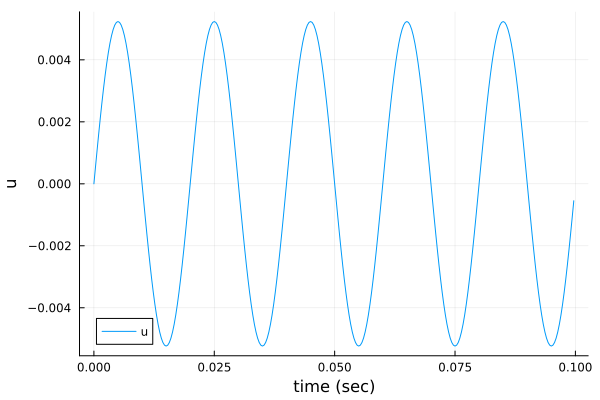

In [4]:
plot(time_steps, u_wave, label = "u")
xlabel!("time (sec)")
ylabel!("u")

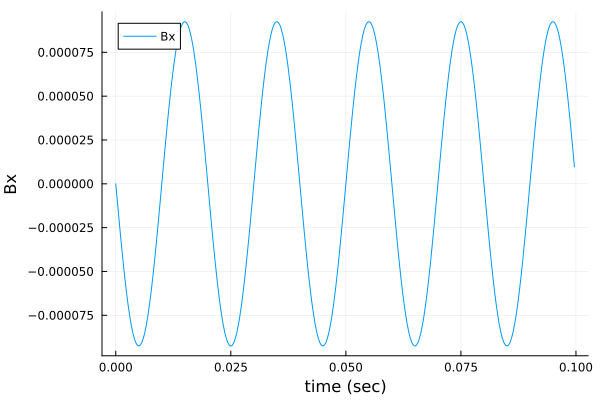

In [5]:
plot(time_steps, Bx_wave, label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

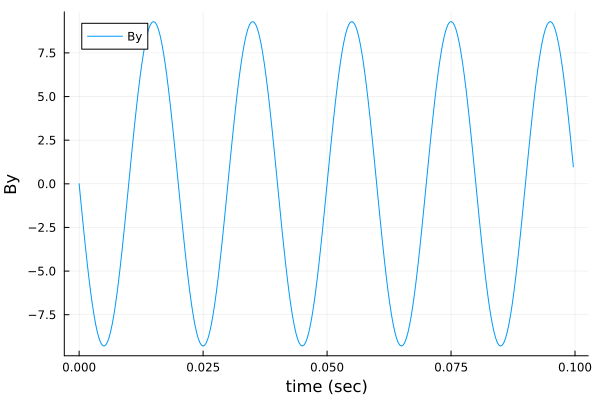

In [6]:
plot(time_steps, By_wave, label = "By")
xlabel!("time (sec)")
ylabel!("By")

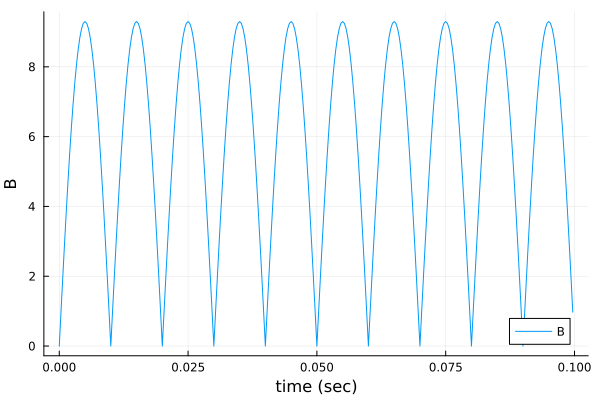

In [7]:
plot(time_steps, B_wave, label = "B")
xlabel!("time (sec)")
ylabel!("B")

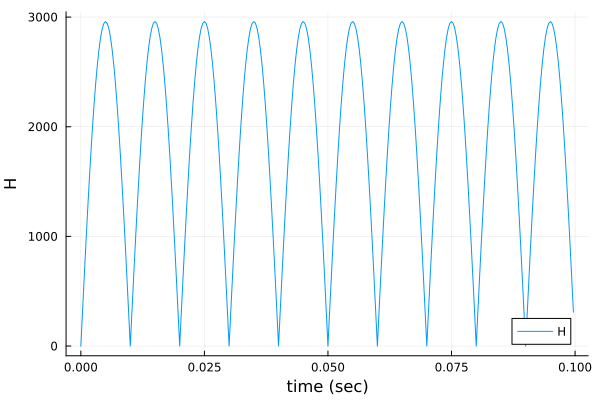

In [8]:
plot(time_steps, H_wave, label = "H")
xlabel!("time (sec)")
ylabel!("H")

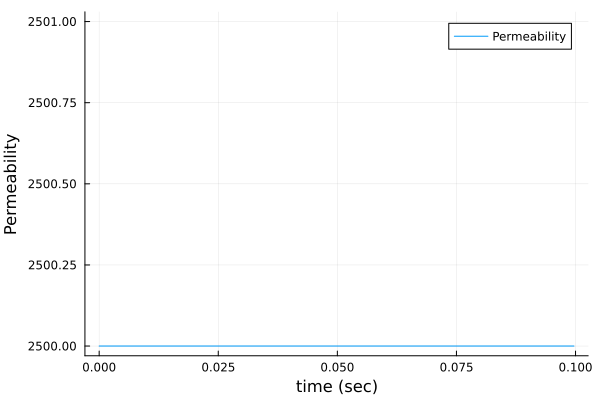

In [9]:
plot(time_steps, 1 ./ reluctivityperelement_wave ./ mu0, label = "Permeability")
xlabel!("time (sec)")
ylabel!("Permeability")

In [10]:
print(" ▸ Saving CSV files .... \r")
start = time_ns()
Bx_mat = DataFrame(hcat(Bx...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Bx_transient.csv", Bx_mat)
By_mat = DataFrame(hcat(By...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_By_transient.csv", By_mat)
B_mat = DataFrame(hcat(B...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_B_transient.csv", B_mat)
Hx_mat = DataFrame(hcat(Hx...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Hx_transient.csv", Hx_mat)
Hy_mat = DataFrame(hcat(Hy...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Hy_transient.csv", Hy_mat)
H_mat = DataFrame(hcat(H...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_H_transient.csv", H_mat)
mag_energy_mat = DataFrame(hcat(mag_energy...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_mag_energy_transient.csv", mag_energy_mat)
permabilityperelement = Vector{Array{Float64,1}}(undef, length(time_steps))
for k = 1:length(time_steps)
    permabilityperelement[k] = reluctivityperelement[k]
end
permability_mat = DataFrame(hcat(permabilityperelement...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_mu_transient.csv", permability_mat)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ CSV files saved ("*string(elapsed)*" seconds)                               ")

 ✓ CSV files saved (10.88 seconds)                               
